In [ ]:
import pandas as pd
import numpy as np
import re
import joblib
import pickle
from sklearn import model_selection
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,confusion_matrix,f1_score,recall_score,precision_score
import sklearn.metrics as metrics
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from PIL import Image
import random
import seaborn as sns

#load data
df = pd.read_csv('text_preprocessing/final_dataset.csv')
df

In [ ]:
#konversi sentimen positif =1 negatif= 0
def convert_label_sentimen(label_sentimen):
    if label_sentimen == "positive":
        return 1
    else:
        return 0

df['label_sentimen'] = df['Sentiment'].apply(convert_label_sentimen)
df.drop(df.columns[[0]], axis= 1,inplace=True)
df


In [ ]:
X= df['tweet_tokens_stemmed'] 
y= df['label_sentimen']
#k-fold cross validation(spliting data)
kfold = StratifiedKFold(n_splits=10, random_state=42, shuffle=True)
for train_idx, val_idx in kfold.split(X, y):
    X_train, X_test = X[train_idx], X[val_idx]
    y_train, y_test = y[train_idx], y[val_idx]
    
X_train.shape, X_test.shape, y_train.shape, y_test.shape


In [ ]:
  # Vektorisasi text menggunakan TF-IDF
tfidf_model = TfidfVectorizer(smooth_idf=False).fit(X_train)
X_train = tfidf_model.transform(X_train)
X_test = tfidf_model.transform(X_test)

print(X_train,X_test)

In [151]:
# Fungsi untuk mengevaluasi fitur
def evaluate_features(X, y, indices, model):
    X_subset = X[:, indices]
    model.fit(X_subset, y)
    predict = model.predict(X_subset)
    return accuracy_score(y, predict)

# Fungsi PSO untuk pemilihan fitur
def pso_feature_selection(X, y, n_particles, n_iterations, model, learning_rate=0.5):
    n_features = X.shape[1]
    particles_position = np.random.choice([0, 1], size=(n_particles, n_features))
    global_best_position = None
    global_best_score = float('-inf')

    for _ in range(n_iterations):
        for particle_position in particles_position:
            selected_indices = np.where(particle_position == 1)[0]
            score = evaluate_features(X, y, selected_indices, model)

            if score > global_best_score:
                global_best_score = score
                global_best_position = selected_indices

        # Update particle positions
        for particle_position in particles_position:
            for i in range(len(particle_position)):
                if np.random.rand() < 0.5:
                    particle_position[i] = 1 if np.random.rand() < 0.5 else 0
                else:
                    velocity = 1 / (1 + np.exp(-particle_position[i]))
                    particle_position[i] = 1 if np.random.rand() < velocity else 0

    return global_best_position

In [ ]:
# Pemilihan fitur menggunakan PSO
n_particles = 20
n_iterations = 50
selected_indices = pso_feature_selection(X_train.toarray(), y_train, n_particles, n_iterations)
selected_indices

In [ ]:
# Memilih fitur terbaik untuk data training dan testing
X_train_selected = X_train[:, selected_indices]
X_test_selected = X_test[:, selected_indices]
print("Isi X_train_selected:")
print(X_train_selected)
print("\nIsi X_test_selected:")
print(X_test_selected)

MULTINOMIAL NAIVE BAYES

In [194]:
#klasifikasi
mnb_selected = MultinomialNB()
mnb_selected.fit(X_train_selected, y_train)
predict_selected = mnb_selected.predict(X_test_selected)
predict_selected

array([1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1,
       1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0], dtype=int64)

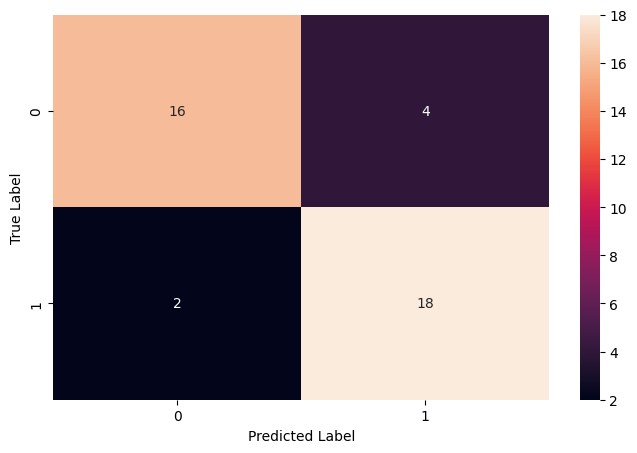

In [195]:
#confusion matrix model
f, ax = plt.subplots(figsize=(8,5))
sns.heatmap(confusion_matrix(y_test, predict_selected), annot=True, fmt=".0f", ax=ax)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [196]:
# Skor akurasi model
print('accuracy after PSO feature selection for Multinomial : ')
print(accuracy_score(y_test, predict_selected)*100)

accuracy after PSO feature selection for Multinomial : 
85.0


BERNOULLI NAIVE BAYES

In [187]:
#klasifikasi
bnb_selected = BernoulliNB()
bnb_selected.fit(X_train_selected, y_train)
predict_selected_bernoulli = bnb_selected.predict(X_test_selected)

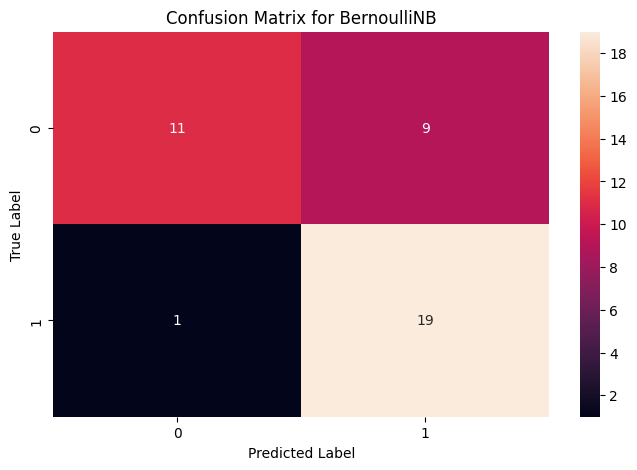

In [185]:
#confusion matrix model BernoulliNB
f, ax = plt.subplots(figsize=(8,5))
sns.heatmap(confusion_matrix(y_test, predict_selected_bernoulli), annot=True, fmt=".0f", ax=ax)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix for BernoulliNB")
plt.show()

In [184]:
print('Accuracy after PSO feature selection for BernoulliNB: ')
print(accuracy_score(y_test, predict_selected_bernoulli)*100)

Accuracy after PSO feature selection for BernoulliNB: 
75.0


GAUSSIAN NAIVE BAYES

In [234]:
# Pemilihan fitur menggunakan PSO untuk GaussianNB
n_particles = 10
n_iterations = 50
gaussian_nb = GaussianNB()
selected_indices_gaussian = pso_feature_selection(X_train.toarray(), y_train, n_particles, n_iterations, gaussian_nb)

In [235]:
# Memilih fitur terbaik untuk data training dan testing menggunakan GaussianNB
X_train_selected_gaussian = X_train[:, selected_indices_gaussian]
X_test_selected_gaussian = X_test[:, selected_indices_gaussian]


In [236]:
# Klasifikasi menggunakan GaussianNB
gaussian_nb_selected = GaussianNB()
gaussian_nb_selected.fit(X_train_selected_gaussian.toarray(), y_train)
predict_selected_gaussian = gaussian_nb_selected.predict(X_test_selected_gaussian.toarray())

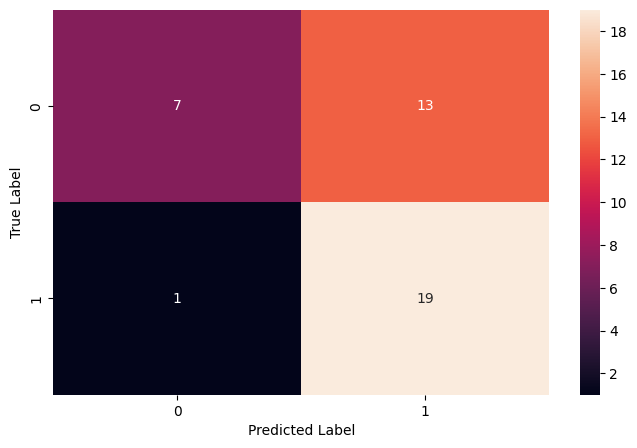

In [239]:
#confusion matrix model GaussianNB
f, ax = plt.subplots(figsize=(8,5))
sns.heatmap(confusion_matrix(y_test, predict_selected_gaussian), annot=True, fmt=".0f", ax=ax)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [238]:
print('Accuracy after PSO feature selection for GaussianNB: ')
print(accuracy_score(y_test, predict_selected_gaussian)*100)

Accuracy after PSO feature selection for GaussianNB: 
65.0
